In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the background image
background_image_path = '/content/gdrive/My Drive/Ray Tracing Project/sightpy/backgrounds/lake.png'
background_image = Image.open(background_image_path)
background_image = np.array(background_image) / 255.0

def get_background_color(ray_direction, cube_map):
    direction = ray_direction / np.linalg.norm(ray_direction)
    abs_direction = np.abs(direction)
    major_axis = np.argmax(abs_direction)
    face_dir = np.sign(ray_direction[major_axis])
    u = v = 0
    face_row = 1
    if major_axis == 1:
        face_row = 0 if face_dir > 0 else 2
    face_width = cube_map.shape[1] / 4
    face_height = cube_map.shape[0] / 3
    if major_axis == 0:
        u = (direction[2] / direction[0] + 1) / 2.0
        v = (1.0 - direction[1] / direction[0]) / 2.0
        face_col = 1 if face_dir > 0 else 3
        v = 1.0 - v if face_dir < 0 else v
        u = 1.0 - u if face_dir > 0 else u
    elif major_axis == 1:
        u = (direction[0] / direction[1] + 1) / 2.0
        v = (direction[2] / direction[1] + 1) / 2.0
        face_col = 1
        (u, v) = (v, u) if face_dir > 0 else (u, v)
        u = 1.0 - u if face_dir > 0 else u
    elif major_axis == 2:
        u = (direction[0] / direction[2] + 1) / 2.0
        v = (1.0 - direction[1] / direction[2]) / 2.0
        face_col = 0 if face_dir > 0 else 2
        v = 1.0 - v if face_dir < 0 else v
        u = 1.0 - u if face_dir > 0 else u
    pixel_x = int(face_col * face_width + u * face_width) % cube_map.shape[1]
    pixel_y = int(face_row * face_height + v * face_height) % cube_map.shape[0]
    return cube_map[pixel_y, pixel_x]




class Sphere:
    def __init__(self, center, radius, color, specular=10, reflective=0.5):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective

    def intersect(self, ray):
        L = self.center - ray.origin
        tca = np.dot(L, ray.direction)
        d2 = np.dot(L, L) - tca * tca
        if d2 > self.radius * self.radius:
            return float('inf'), None
        thc = np.sqrt(self.radius * self.radius - d2)
        t0 = tca - thc
        t1 = tca + thc
        if t0 < 0 and t1 < 0:
            return float('inf'), None
        if t0 < 0:
            return t1, self
        return t0, self

class Light:
    def __init__(self, position, color, intensity):
        self.position = np.array(position)
        self.color = np.array(color)
        self.intensity = intensity



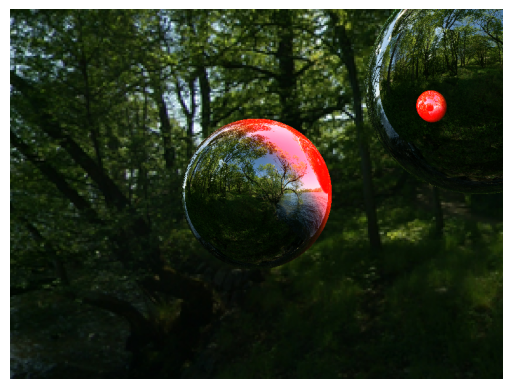

In [ ]:

class Ray:
    def __init__(self, origin, direction):
        self.origin = np.array(origin)
        self.direction = np.array(direction)
        self.direction /= np.linalg.norm(self.direction)

class Scene:
    def __init__(self):
        self.objects = []
        self.lights = []

    def add_object(self, obj):
        self.objects.append(obj)

    def add_light(self, light):
        self.lights.append(light)

def reflect(ray, normal):
    return ray - 2 * np.dot(ray, normal) * normal

def compute_lighting(point, normal, view, specular, lights):
    intensity = 0
    length_n = np.linalg.norm(normal)
    length_v = np.linalg.norm(view)
    for light in lights:
        if length_n == 0:
            continue

        # Diffuse lighting
        to_light = light.position - point
        if np.linalg.norm(to_light) == 0:
            continue

        to_light /= np.linalg.norm(to_light)
        dot = np.dot(to_light, normal)
        if dot > 0:
            intensity += light.intensity * dot / (np.linalg.norm(to_light) * length_n)

        # Specular lighting
        if specular != -1:
            reflect_dir = 2 * normal * np.dot(normal, to_light) - to_light
            reflect_dir /= np.linalg.norm(reflect_dir)
            spec = np.dot(reflect_dir, view)
            if spec > 0:
                intensity += light.intensity * pow(spec / (np.linalg.norm(reflect_dir) * length_v), specular)
    return intensity

def trace_ray(ray, scene, depth, max_depth=3):
    if depth > max_depth:
        return np.array([0.0, 0.0, 0.0], dtype=np.float64)

    closest_dist = float('inf')
    closest_obj = None
    for obj in scene.objects:
        dist, obj_hit = obj.intersect(ray)
        if obj_hit and dist < closest_dist:
            closest_dist = dist
            closest_obj = obj_hit

    if closest_obj is None:
        return get_background_color(ray.direction, background_image)

    hit_point = ray.origin + ray.direction * closest_dist
    normal = (hit_point - closest_obj.center) / np.linalg.norm(hit_point - closest_obj.center)
    view = -ray.direction
    lighting = compute_lighting(hit_point, normal, view, closest_obj.specular, scene.lights)

    color = (closest_obj.color * lighting).astype(np.float64)

    if closest_obj.reflective > 0:
        reflected_ray_dir = reflect(ray.direction, normal)
        reflected_ray = Ray(hit_point + reflected_ray_dir * 0.001, reflected_ray_dir)
        reflected_color = trace_ray(reflected_ray, scene, depth + 1)
        # print(type(color[0]), "before addition")
        color += reflected_color.astype("float64")
        # print(type(color[0]), "after addition")

    return np.clip(color, 0, 1)


def render(scene, camera, width, height):
    image = np.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            x = (2 * (j + 0.5) / width - 1) * np.tan(np.pi / 8) * width / height
            y = -(2 * (i + 0.5) / height - 1) * np.tan(np.pi / 8)
            ray = Ray(camera, [x, y, 1])

            color = trace_ray(ray, scene, 0)
            image[i, j] = np.clip(color, 0, 1)
    return image

def main():
    width, height = 800, 600
    camera = [0, 0, 0]
    scene = Scene()
    scene.add_object(Sphere([0, 0, 3], 0.5, [1, 0, 0], 3, 0.05))
    scene.add_object(Sphere([2, 1, 4], 1, [0, 1, 0], 10, 0.7))
    scene.add_light(Light([10, 10, 10], [1, 1, 1], 1.5))

    image = render(scene, camera, width, height)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()
